In [6]:
# import libraries
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
import spacy
import os

In [7]:
pd.options.mode.chained_assignment = None
nltk.download('stopwords')

file_prefix = 'hashtag'
text_field = 'hashtag'
bag_size = 1500

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# load data
# csvname="filtered_dataset/"+file_prefix+".csv" #changed
csvname=file_prefix+".csv" #changed
data_orig=pd.read_csv(csvname)
data=data_orig.copy()
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
rows=len(data)

In [9]:
# preprocess text data
def filter_text(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    oldtext=data[text_field][i] 
    newtext=' '.join(re.sub("(@[A-Za-z0-9]+)| (_URL_) | (#[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",str(oldtext)).split()) # removes hashtags, https links, usernames.
    newtext= re.sub('[^a-zA-Z0-9]'," ",str(newtext)) #removes all other characters other than English Alpha-Numeric Characters
    newtext=newtext.lower()
    newtext=newtext.split()
    data[text_field][i]=newtext
  return data

In [10]:
filtered_data=filter_text(data)
filtered_data

,hashtag,class
0,"[aidsmaplive, monkeypox]",0
1,[nan],0
2,"[healthcare, monkeypox]",0
3,[nan],0
4,[nan],0
...,...,...
5782,[nan],1
5783,[nan],1
5784,[nan],1
5785,[nan],1


In [11]:
def porterstemming(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    ps=PorterStemmer()
    oldtext=data[text_field][i]
    newtext= [ps.stem(word) for word in oldtext if word not in set(stopwords.words('english'))]
    newtext=' '.join(newtext)
    data[text_field][i]=newtext
  return data

In [12]:
portered_stemmed_data=porterstemming(filtered_data)
portered_stemmed_data

,hashtag,class
0,aidsmapl monkeypox,0
1,nan,0
2,healthcar monkeypox,0
3,nan,0
4,nan,0
...,...,...
5782,nan,1
5783,nan,1
5784,nan,1
5785,nan,1


In [13]:
def lemmatization(in_data):
  data = in_data.copy()
  spc = spacy.load("en_core_web_sm")
  for i in range (0,rows):
    oldtext = ' '.join(item for item in data[text_field][i])
    doc = spc(oldtext)
    newtext=' '.join([str(token) for token in doc if token not in set(stopwords.words("english"))])
    newtext = re.sub(r'\s+', ' ', newtext)
    data[text_field][i]=newtext
  return data

In [14]:
lemmatization_data=lemmatization(filtered_data)
lemmatization_data

,hashtag,class
0,aidsmaplive monkeypox,0
1,nan,0
2,healthcare monkeypox,0
3,nan,0
4,nan,0
...,...,...
5782,nan,1
5783,nan,1
5784,nan,1
5785,nan,1


In [15]:
def create_corpus_and_y(data):
  y=np.array(data["class"])
  corpus=[data[text_field][i] for i in range(len(data)) if len(data)!=0]
  return (y,corpus)

In [16]:
y_portered,portered_corpus=create_corpus_and_y(portered_stemmed_data)
y_lemmatization,lemmatization_corpus=create_corpus_and_y(lemmatization_data)

In [17]:
def count_vec(corpus):
  from sklearn.feature_extraction.text import CountVectorizer
  cv = CountVectorizer(max_features = bag_size)
  X = cv.fit_transform(corpus).toarray()
  return X

In [18]:
def tf_idf_vec(corpus):
  from sklearn.feature_extraction.text import TfidfVectorizer
  vectorizer = TfidfVectorizer(max_features=bag_size) # Add min_df, max_df parameters as well
  vectorizer.fit(corpus)
  X = vectorizer.transform(corpus)
  X=X.toarray()
  return X

In [19]:
X_portered_CV=count_vec(portered_corpus)
X_lemmatization_CV=count_vec(lemmatization_corpus)

In [20]:
df_portered_CV = pd.DataFrame(X_portered_CV)
df_portered_CV['class'] = y_portered
df_portered_CV

,0,1,2,3,4,5,6,7,8,9,...,739,740,741,742,743,744,745,746,747,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
df_lemmatization_CV = pd.DataFrame(X_lemmatization_CV)
df_lemmatization_CV['class'] = y_lemmatization
df_lemmatization_CV

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
X_portered_TF_IDF=tf_idf_vec(portered_corpus)
X_lemmatization_TF_IDF=tf_idf_vec(lemmatization_corpus)

In [23]:
df_portered_TF_IDF = pd.DataFrame(X_portered_TF_IDF)
df_portered_TF_IDF['class'] = y_portered
df_portered_TF_IDF

,0,1,2,3,4,5,6,7,8,9,...,739,740,741,742,743,744,745,746,747,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [24]:
df_lemmatization_TF_IDF = pd.DataFrame(X_lemmatization_TF_IDF)
df_lemmatization_TF_IDF['class'] = y_lemmatization
df_lemmatization_TF_IDF

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [25]:
#write processed dataset to .csv
os.makedirs('processed_dataset', exist_ok=True)
df_portered_CV.to_csv('processed_dataset/'+file_prefix+'_portered_CV.csv',index=False) 
df_lemmatization_CV.to_csv('processed_dataset/'+file_prefix+'_lemmatization_CV.csv',index=False)

In [26]:
df_portered_TF_IDF.to_csv('processed_dataset/'+file_prefix+'_portered_TF_IDF.csv',index=False) 
df_lemmatization_TF_IDF.to_csv('processed_dataset/'+file_prefix+'_lemmatization_TF_IDF.csv',index=False)

In [27]:
result_list = []

## PCA starts

In [28]:
# def split_data_train_test_split(X,y):
#  from sklearn.model_selection import train_test_split
#  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#  return(X_train, X_test,y_train,y_test)

import math
from sklearn.model_selection import train_test_split

def split_data_train_test_split(X,y):
    X_class = {
        0: [],
        1: []}
    for i in range(len(y)):
        X_class[y[i]].append(X[i])
    X_0_candidate = X_class[0][:len(X_class[1])]
    X_0_add = X_class[0][len(X_class[1]):]
    
    X_candidate = np.concatenate((X_0_candidate, X_class[1]))
    
    y_candidate = np.array([0 for i in range(len(X_0_candidate))])
    y_candidate = np.concatenate((y_candidate,np.array([1 for i in range(len(X_0_candidate))])))

    y_0_add = np.array([0 for i in range(len(X_0_add))])
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_candidate, y_candidate, test_size = 0.2, random_state = 0)

#     X_test = np.concatenate((X_test, X_0_add))
#     y_test = np.concatenate((y_test, y_0_add))
    
    return(X_train, X_test,y_train,y_test)

In [33]:
from sklearn.decomposition import PCA
def perform_PCA (X_train, y_train, total_components, n_components):
  pca = PCA(n_components=total_components, random_state=0)
  pca.fit(X_train)
  X_pca = pca.transform(X_train)

  print("Variance explained by all", total_components, "principal components =", sum(pca.explained_variance_ratio_ * 100))

  csum = np.cumsum(pca.explained_variance_ratio_ * 100)
  # print(csum)
  print ()

  # plot 
  import matplotlib.pyplot as plt
  plt.plot(csum)
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  # plt.savefig('elbow_plot.png', dpi=100)

  # find the number of components
  print (csum[n_components-1])

  x_train_pca=[x[:n_components] for x in X_pca]

  print (len(x_train_pca[0]))
  print ()

  return x_train_pca

In [34]:
# PCA on lemmatization data
y = df_lemmatization_TF_IDF['class']
X_lemmatization_tf = df_lemmatization_TF_IDF.copy()
X_lemmatization_tf.drop ('class', axis=1, inplace=True)

X_lemmatization_cv = df_lemmatization_CV.copy()
X_lemmatization_cv.drop ('class', axis=1, inplace=True)

0.12987012987012986
Variance explained by all 770 principal components = 99.99999999999969

97.09633858568367
300



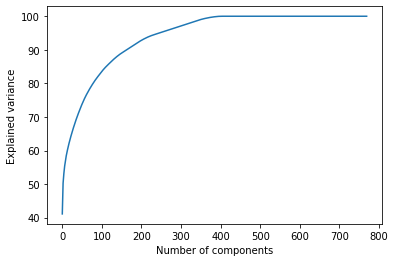

In [35]:
# PCA lemmatization CV
total_components = min(len(df_lemmatization_CV.columns)-1, len(X_lemmatization_cv))
print (100/total_components)
n_components = 300
X_lemmatization_cv_PCA = perform_PCA (X_lemmatization_cv, y, total_components, n_components)

0.12987012987012986
Variance explained by all 770 principal components = 99.99999999999935

97.03755149449566
300



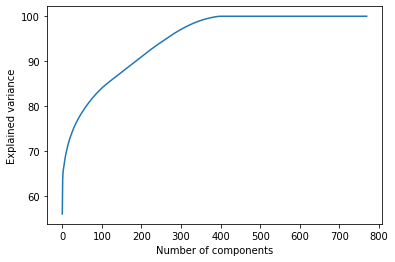

In [37]:
# PCA lemmatization TF IDF
total_components = min(len(df_lemmatization_TF_IDF.columns)-1, len(X_lemmatization_tf))
print (100/total_components)
n_components = 300
X_lemmatization_tf_PCA = perform_PCA (X_lemmatization_tf, y, total_components, n_components)

In [38]:
X_train_lemmatization_cv, X_test_lemmatization_cv,y_train_lemmatization_cv,y_test_lemmatization_cv=split_data_train_test_split(X_lemmatization_cv_PCA,y)
X_train_lemmatization_tf, X_test_lemmatization_tf,y_train_lemmatization_tf,y_test_lemmatization_tf=split_data_train_test_split(X_lemmatization_tf_PCA,y)

In [39]:
# PCA on portered data
y = df_portered_TF_IDF['class']
X_portered_tf = df_portered_TF_IDF.copy()
X_portered_tf.drop ('class', axis=1, inplace=True)

X_portered_cv = df_portered_CV.copy()
X_portered_cv.drop ('class', axis=1, inplace=True)

0.13368983957219252
Variance explained by all 748 principal components = 100.00000000000061

97.28755095684176
300



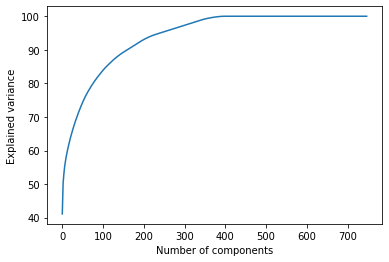

In [40]:
# PCA portered CV
total_components = min(len(df_portered_CV.columns)-1, len(X_portered_cv))
print (100/total_components)
n_components = 300
X_portered_cv_PCA = perform_PCA (X_portered_cv, y, total_components, n_components)

0.13368983957219252
Variance explained by all 748 principal components = 99.99999999999972

97.26150632923309
300



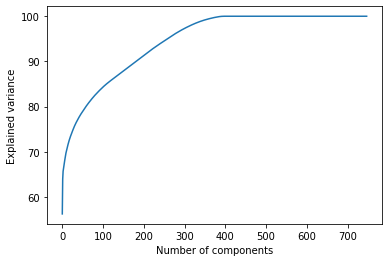

In [41]:
# PCA portered TF IDF
total_components = min(len(df_portered_TF_IDF.columns)-1, len(X_portered_tf))
print (100/total_components)
n_components = 300
X_portered_tf_PCA = perform_PCA (X_portered_tf, y, total_components, n_components)

In [42]:
X_train_portered_cv, X_test_portered_cv,y_train_portered_cv,y_test_portered_cv=split_data_train_test_split(X_portered_cv_PCA,y)
X_train_portered_tf, X_test_portered_tf,y_train_portered_tf,y_test_portered_tf=split_data_train_test_split(X_portered_tf_PCA,y)

#Run Models

In [43]:
class Data:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

class Result:
    def __init__(self, y_test, y_pred, label=None):
        self.label = label
        self.accuracy = accuracy_score(y_test,y_pred) * 100
        self.precision = precision_score(y_test, y_pred, average='binary') * 100
        self.recall = recall_score(y_test, y_pred, average='binary') * 100
        self.f1 = f1_score(y_test, y_pred, average='binary') * 100
        self.confusion_matrix = confusion_matrix(y_test, y_pred)
        
    def show(self):
        print("Accuracy = ",self.accuracy,"%")
        print("Precision = ",self.precision)
        print("Recall = ",self.recall)
        print("F1 Score = ",self.f1)
        print("Confusion Matrix: \n", self.confusion_matrix)
        
def getResult(data, res, model_name):
    result = Result(data.y_test, res)
    result.show()
    result_list.append ([model_name, result.accuracy, result.precision, result.recall, result.f1])
    return result

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

def getBestModel(data, model, param_grid, cv=10):
    scorer = make_scorer(metrics.f1_score , average='binary')
    grid = GridSearchCV(model, 
                        param_grid,
                        cv=cv,
                        scoring=scorer)


    grid.fit(data.x_train, data.y_train)
    
    return grid

In [54]:
from sklearn.svm import SVC
from sklearn import svm

def runSVM(data, model_name):
    svm_param_grid = {'C': [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10], 
                      'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                      'gamma': [1,0.1,0.01,0.001]
                     } 

    grid = getBestModel(data, svm.SVC(), svm_param_grid, cv=2)

    y_pred = grid.predict(data.x_test)
    getResult(data, y_pred, model_name)
    print(grid.best_params_)
    return grid

from sklearn.ensemble import RandomForestClassifier

def runRF(data, model_name):
    random_forest_params_grid = {
        'n_estimators': [i for i in range(100, 1000, 100)],
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'random_state': [0]
    }

    grid = getBestModel(data, RandomForestClassifier(), random_forest_params_grid, 2)

    y_pred = grid.predict(data.x_test)
    getResult(data, y_pred, model_name)
    print(grid.best_params_)
    return grid
    
from sklearn.tree import DecisionTreeClassifier

def runDT(data, model_name):
    decision_tree_params = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [i for i in range(100, 1000, 100)],
        'max_features': ['sqrt', 'log2'],
        'random_state': [0]
    }

    grid = getBestModel(data, DecisionTreeClassifier(), decision_tree_params)

    y_pred = grid.predict(data.x_test)

    getResult(data, y_pred, model_name)

    print(grid.best_params_)
    return grid

from sklearn.neighbors import KNeighborsClassifier

def runKNN(data, model_name):

    knn_params_grid = {
        'n_neighbors': [i for i in [5, 10, 15, 20]],
        'p': [1,2],
        'metric' : ['minkowski','euclidean','manhattan', 'chebyshev'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }

    grid = getBestModel(data, KNeighborsClassifier(), knn_params_grid)

    y_pred = grid.predict(data.x_test)

    getResult(data, y_pred, model_name)

    print(grid.best_params_)
    return grid

from sklearn.naive_bayes import GaussianNB

def runNB(data, model_name):

    nb_params_grid = {
    }

    grid = getBestModel(data, GaussianNB(), nb_params_grid)

    y_pred = grid.predict(data.x_test)

    getResult(data, y_pred, model_name)

    print(grid.best_params_)
    return grid


In [45]:
data_lemmatization_cv = Data(X_train_lemmatization_cv, y_train_lemmatization_cv, X_test_lemmatization_cv, y_test_lemmatization_cv)
data_lemmatization_tf = Data(X_train_lemmatization_tf, y_train_lemmatization_tf, X_test_lemmatization_tf, y_test_lemmatization_tf)
data_portered_cv = Data(X_train_portered_cv, y_train_portered_cv, X_test_portered_cv, y_test_portered_cv)
data_portered_tf = Data(X_train_portered_tf, y_train_portered_tf, X_test_portered_tf, y_test_portered_tf)

In [46]:
print('Lemmatization CV')
grid = runSVM(data_lemmatization_cv, 'svm_lemma_cv')

print('\nLemmatization TF-IDF')
grid = runSVM(data_lemmatization_tf, 'svm_lemma_tf')

print('\nPortered CV')
grid = runSVM(data_portered_cv, 'svm_port_cv')

print('\nPortered TF-IDF')
grid = runSVM(data_portered_tf, 'svm_port_tf')

Lemmatization CV
Accuracy =  56.54205607476636 %
Precision =  53.2258064516129
Recall =  94.28571428571428
F1 Score =  68.04123711340205
Confusion Matrix: 
 [[ 44 174]
 [ 12 198]]
{'C': 1, 'gamma': 1, 'kernel': 'linear'}

Lemmatization TF-IDF
Accuracy =  56.54205607476636 %
Precision =  53.2258064516129
Recall =  94.28571428571428
F1 Score =  68.04123711340205
Confusion Matrix: 
 [[ 44 174]
 [ 12 198]]
{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}

Portered CV
Accuracy =  56.30841121495327 %
Precision =  53.06666666666666
Recall =  94.76190476190476
F1 Score =  68.03418803418803
Confusion Matrix: 
 [[ 42 176]
 [ 11 199]]
{'C': 10, 'gamma': 1, 'kernel': 'sigmoid'}

Portered TF-IDF
Accuracy =  57.242990654205606 %
Precision =  53.6
Recall =  95.71428571428572
F1 Score =  68.71794871794872
Confusion Matrix: 
 [[ 44 174]
 [  9 201]]
{'C': 1, 'gamma': 1, 'kernel': 'poly'}


In [47]:
print('Lemmatization CV')
grid = runRF(data_lemmatization_cv, 'rf_lemma_cv')

print('\nLemmatization TF-IDF')
grid = runRF(data_lemmatization_tf, 'rf_lemma_tf')

print('\nPortered CV')
grid = runRF(data_portered_cv, 'rf_port_cv')

print('\nPortered TF-IDF')
grid = runRF(data_portered_tf, 'rf_port_tf')

Lemmatization CV
Accuracy =  56.77570093457944 %
Precision =  53.333333333333336
Recall =  95.23809523809523
F1 Score =  68.37606837606836
Confusion Matrix: 
 [[ 43 175]
 [ 10 200]]
{'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 700, 'random_state': 0}

Lemmatization TF-IDF
Accuracy =  57.242990654205606 %
Precision =  53.6
Recall =  95.71428571428572
F1 Score =  68.71794871794872
Confusion Matrix: 
 [[ 44 174]
 [  9 201]]
{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 0}

Portered CV
Accuracy =  56.77570093457944 %
Precision =  53.35120643431635
Recall =  94.76190476190476
F1 Score =  68.26758147512865
Confusion Matrix: 
 [[ 44 174]
 [ 11 199]]
{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300, 'random_state': 0}

Portered TF-IDF
Accuracy =  56.54205607476636 %
Precision =  53.

In [48]:
print('Lemmatization CV')
grid = runDT(data_lemmatization_cv, 'dt_lemma_cv')

print('\nLemmatization TF-IDF')
grid = runDT(data_lemmatization_tf, 'dt_lemma_tf')

print('\nPortered CV')
grid = runDT(data_portered_cv, 'dt_port_cv')

print('\nPortered TF-IDF')
grid = runDT(data_portered_tf, 'dt_port_tf')

Lemmatization CV
Accuracy =  55.140186915887845 %
Precision =  52.34375
Recall =  95.71428571428572
F1 Score =  67.67676767676768
Confusion Matrix: 
 [[ 35 183]
 [  9 201]]
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'random_state': 0}

Lemmatization TF-IDF
Accuracy =  56.54205607476636 %
Precision =  53.17460317460318
Recall =  95.71428571428572
F1 Score =  68.36734693877551
Confusion Matrix: 
 [[ 41 177]
 [  9 201]]
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'random_state': 0}

Portered CV
Accuracy =  55.84112149532711 %
Precision =  52.74151436031331
Recall =  96.19047619047619
F1 Score =  68.12816188870153
Confusion Matrix: 
 [[ 37 181]
 [  8 202]]
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'random_state': 0}

Portered TF-IDF
Accuracy =  56.54205607476636 %
Precision =  53.17460317460318
Recall =  95.71428571428572
F1 Score =  68.36734693877551
Confusion Matrix: 
 [[ 41 177]
 [  9 201]]
{'criterion': 'entropy', 

In [55]:
print('Lemmatization CV')
grid = runKNN(data_lemmatization_cv, 'knn_lemma_cv')

print('\nLemmatization TF-IDF')
grid = runKNN(data_lemmatization_tf, 'knn_lemma_tf')

print('\nPortered CV')
grid = runKNN(data_portered_cv, 'knn_port_cv')

print('\nPortered TF-IDF')
grid = runKNN(data_portered_tf, 'knn_port_tf')

Lemmatization CV
Accuracy =  56.074766355140184 %
Precision =  52.956989247311824
Recall =  93.80952380952381
F1 Score =  67.69759450171821
Confusion Matrix: 
 [[ 43 175]
 [ 13 197]]
{'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 5, 'p': 1}

Lemmatization TF-IDF
Accuracy =  56.30841121495327 %
Precision =  53.00261096605744
Recall =  96.66666666666667
F1 Score =  68.46543001686341
Confusion Matrix: 
 [[ 38 180]
 [  7 203]]
{'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 5, 'p': 1}

Portered CV
Accuracy =  56.54205607476636 %
Precision =  53.2258064516129
Recall =  94.28571428571428
F1 Score =  68.04123711340205
Confusion Matrix: 
 [[ 44 174]
 [ 12 198]]
{'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 5, 'p': 1}

Portered TF-IDF
Accuracy =  56.54205607476636 %
Precision =  53.191489361702125
Recall =  95.23809523809523
F1 Score =  68.25938566552901
Confusion Matrix: 
 [[ 42 176]
 [ 10 200]]
{'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 

In [49]:
print('Lemmatization CV')
grid = runNB(data_lemmatization_cv, 'nb_lemma_cv')

print('\nLemmatization TF-IDF')
grid = runNB(data_lemmatization_tf, 'nb_port_tf')

print('\nPortered CV')
grid = runNB(data_portered_cv, 'nb_port_cv')

print('\nPortered TF-IDF')
grid = runNB(data_portered_tf, 'nb_port_tf')

Lemmatization CV
Accuracy =  53.97196261682243 %
Precision =  51.61290322580645
Recall =  99.04761904761905
F1 Score =  67.86296900489396
Confusion Matrix: 
 [[ 23 195]
 [  2 208]]
{}

Lemmatization TF-IDF
Accuracy =  53.97196261682243 %
Precision =  51.61290322580645
Recall =  99.04761904761905
F1 Score =  67.86296900489396
Confusion Matrix: 
 [[ 23 195]
 [  2 208]]
{}

Portered CV
Accuracy =  53.73831775700935 %
Precision =  51.515151515151516
Recall =  97.14285714285714
F1 Score =  67.32673267326732
Confusion Matrix: 
 [[ 26 192]
 [  6 204]]
{}

Portered TF-IDF
Accuracy =  53.73831775700935 %
Precision =  51.49253731343284
Recall =  98.57142857142858
F1 Score =  67.64705882352942
Confusion Matrix: 
 [[ 23 195]
 [  3 207]]
{}


Write Results to csv

In [56]:
result_list

[['svm_lemma_cv',
  56.54205607476636,
  53.2258064516129,
  94.28571428571428,
  68.04123711340205],
 ['svm_lemma_tf',
  56.54205607476636,
  53.2258064516129,
  94.28571428571428,
  68.04123711340205],
 ['svm_port_cv',
  56.30841121495327,
  53.06666666666666,
  94.76190476190476,
  68.03418803418803],
 ['svm_port_tf',
  57.242990654205606,
  53.6,
  95.71428571428572,
  68.71794871794872],
 ['rf_lemma_cv',
  56.77570093457944,
  53.333333333333336,
  95.23809523809523,
  68.37606837606836],
 ['rf_lemma_tf',
  57.242990654205606,
  53.6,
  95.71428571428572,
  68.71794871794872],
 ['rf_port_cv',
  56.77570093457944,
  53.35120643431635,
  94.76190476190476,
  68.26758147512865],
 ['rf_port_tf',
  56.54205607476636,
  53.2258064516129,
  94.28571428571428,
  68.04123711340205],
 ['dt_lemma_cv',
  55.140186915887845,
  52.34375,
  95.71428571428572,
  67.67676767676768],
 ['dt_lemma_tf',
  56.54205607476636,
  53.17460317460318,
  95.71428571428572,
  68.36734693877551],
 ['dt_port_cv'

In [58]:
df = pd.DataFrame(result_list)
df.columns =['Model Name','Accuracy','Precision', 'Recall', 'F1-Score']

In [59]:
df.to_csv ('results_hashtag_balanced_train_discard_excess0.csv', index=False)